In [76]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import scipy

from sklearn.decomposition import PCA

from utils.depth_camera import DepthCamera
from scipy.ndimage import gaussian_filter1d

plt.style.use("ggplot")

In [64]:
def get_rotation_matrix(degrees):
    """
    Generate a 3x3 rotation matrix given the three Euler angles in degrees.
    The Euler angles are in the order roll, pitch, and yaw (intrinsic rotations).
    """

    # Convert degrees to radians
    angles = np.radians(degrees)

    # Compute the sin and cos values of the angles
    c1, c2, c3 = np.cos(angles)
    s1, s2, s3 = np.sin(angles)

    # Compute the rotation matrix using the rotation matrix multiplication formula
    R_x = np.array([[1, 0, 0], [0, c1, -s1], [0, s1, c1]])
    R_y = np.array([[c2, 0, s2], [0, 1, 0], [-s2, 0, c2]])
    R_z = np.array([[c3, -s3, 0], [s3, c3, 0], [0, 0, 1]])
    R = np.dot(np.dot(R_z, R_y), R_x)

    return R

In [102]:
data_dir = "data/raw_data"
experiment = "exp_8"
trial = "trial_2"
subject = "subject-1"
sequence = 2

file_name = f"{experiment}__{trial}__{subject}__{sequence:02d}"
pose_file = os.path.join("data/trajectories/groundtruth", experiment, f"{file_name}.pose.npz")

motion_dir = os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "motion")

accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000
print(f"Frame rate: {frame_rate:.2f} Hz")

Frame rate: 400.91 Hz


In [103]:
# apply gaussian filter to smooth acceleration and gyro data
imu_df.loc[:, "xa"] = gaussian_filter1d(imu_df.xa.values, sigma=10)
imu_df.loc[:, "ya"] = gaussian_filter1d(imu_df.ya.values, sigma=10)
imu_df.loc[:, "za"] = gaussian_filter1d(imu_df.za.values, sigma=10)
imu_df.loc[:, "xg"] = gaussian_filter1d(imu_df.xg.values, sigma=10)
imu_df.loc[:, "yg"] = gaussian_filter1d(imu_df.yg.values, sigma=10)
imu_df.loc[:, "zg"] = gaussian_filter1d(imu_df.zg.values, sigma=10)

### Android

In [58]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel_android.csv"), names=["timestamp", "x", "y", "z"])
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro_android.csv"), names=["timestamp", "x", "y", "z"])

accel_df.loc[:, "gyro_t"] = accel_df.apply(lambda x: helpers.nearest(gyro_df.timestamp.values, x.timestamp), axis=1)

imu_df = pd.merge(
    accel_df.loc[:, ["gyro_t", "x", "y", "z"]],
    gyro_df.loc[:, ["timestamp", "x", "y", "z"]],
    left_on="gyro_t",
    right_on="timestamp",
    suffixes=("a", "g")
)

imu_df.drop("gyro_t", axis=1, inplace=True)
imu_df = imu_df.loc[:, ["timestamp", "xa", "ya", "za", "xg", "yg", "zg"]]

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000
print(f"Frame rate: {frame_rate:.2f} Hz")

Frame rate: 50.04 Hz


<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

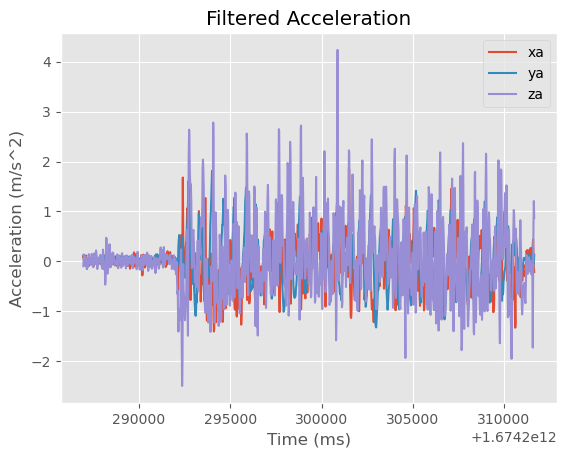

In [59]:
imu_df.iloc[200:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration")

In [60]:
imu_df = imu_df.iloc[200:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [61]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    # velocity = np.dot(rotation_matrix.T, np.array([*velocity, 1]))[:3]
    
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 1235/1235 [00:00<00:00, 2398.54it/s]


In [62]:
# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
end_t = helpers.nearest(imu_df.timestamp.values, sequence_ts[-1])

start_index = np.where(sequence_ts == start_t)[0][0]
end_imu_index = np.where(imu_df.timestamp.values == end_t)[0][0]

# create trajectory as a pcd
xyz = imu_df.iloc[:end_imu_index, 8:].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  14.799045512605629
GT Distance:  10.17501507322044


In [64]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [ ]:
x_resampled, t_resampled = scipy.signal.resample(accel_df.x.values, t=accel_df.timestamp.values, num=int(len(accel_df.x.values) * 0.25), domain="time")

plt.figure(figsize=(20, 5))
plt.plot(accel_df.timestamp.values, accel_df.x.values)
plt.plot(t_resampled, x_resampled)
plt.legend(["Original", "Resampled"])

### Quaternion

In [68]:
def get_quaternion_from_euler(roll, pitch, yaw):
  """
  Convert an Euler angle to a quaternion.
 
  Input
    :param roll: The roll (rotation around x-axis) angle in radians.
    :param pitch: The pitch (rotation around y-axis) angle in radians.
    :param yaw: The yaw (rotation around z-axis) angle in radians.
 
  Output
    :return qx, qy, qz, qw: The orientation in quaternion [x,y,z,w] format
  """
  qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
  qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
  qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
  qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
 
  return [qx, qy, qz, qw],[qx, -qy, -qz, -qw]
 
 
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return [-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0]

In [221]:
win_len = int(frame_rate * 4)
gravity = imu_df.iloc[:win_len, 1:4].mean().values
gravity = np.array([0, *gravity])
imu_df = imu_df.iloc[win_len:]

print(f"gravity: {gravity} - magnitude: {np.linalg.norm(gravity):.2f}")

gravity: [ 0.          0.17265518 -9.70040565 -1.11191288] - magnitude: 9.77


In [223]:
angle = [0, 0, 0]

for n in tqdm.trange(1, imu_df.shape[0]):
    acceleration = imu_df.iloc[n, 1:4].values
    omega = imu_df.iloc[n, 4:7].values
    
    dt = (imu_df.iloc[n, 0] - imu_df.iloc[n - 1, 0]) / 1e3
    
    angle = [angle[j] + omega[j] * dt for j in range(3)]
    
    q = get_quaternion_from_euler(angle[0], angle[1], angle[2])
    
    linear_acceleration = acceleration + np.array(quaternion_multiply(quaternion_multiply(q[0] ,gravity), q[1])[1:])
    
    imu_df.iloc[n, 1] = linear_acceleration[0]
    imu_df.iloc[n, 2] = linear_acceleration[1]
    imu_df.iloc[n, 3] = linear_acceleration[2]
    
# remove first row
imu_df = imu_df.iloc[1:]

100%|██████████| 6415/6415 [00:01<00:00, 3528.61it/s]


<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

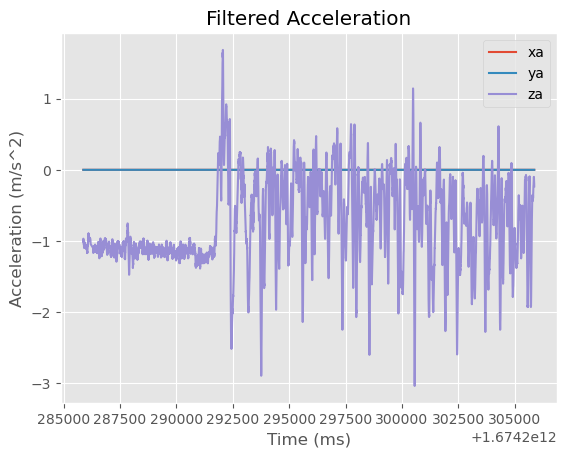

In [249]:
imu_df.plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration")

In [250]:
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

C:\Users\darshanakg.2021\AppData\Local\Temp\ipykernel_16376\3423552486.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imu_df.loc[:, "x"] = np.zeros(len(imu_df))
C:\Users\darshanakg.2021\AppData\Local\Temp\ipykernel_16376\3423552486.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imu_df.loc[:, "y"] = np.zeros(len(imu_df))
C:\Users\darshanakg.2021\AppData\Local\Temp\ipykernel_16376\3423552486.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [251]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 8017/8017 [00:02<00:00, 3424.06it/s]


In [252]:
# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
end_t = helpers.nearest(imu_df.timestamp.values, sequence_ts[-1])

start_index = np.where(sequence_ts == start_t)[0][0]
end_imu_index = np.where(imu_df.timestamp.values == end_t)[0][0]

# create trajectory as a pcd
xyz = imu_df.iloc[:end_imu_index, 8:].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  141.10258497489468
GT Distance:  10.17501507322044


In [253]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

### Low-pass filter

In [81]:
# Low pass filter
alpha = 0.8
gravity = [0, 0, 0]
# only for analysis
gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

for i in tqdm.trange(imu_df.shape[0]):
    for j in range(3):
        gravity[j] = alpha * gravity[j] + (1 - alpha) * imu_df.iloc[i, 1 + j]
        imu_df.iloc[i, 1 + j] = imu_df.iloc[i, 1 + j] - gravity[j]
    
    gravity_df = pd.concat([gravity_df, pd.DataFrame({"timestamp": [imu_df.iloc[i, 0]], "x": [gravity[0]], "y": [gravity[1]], "z": [gravity[2]]})], ignore_index=True)

100%|██████████| 8019/8019 [00:07<00:00, 1124.59it/s]


<AxesSubplot:title={'center':'Gravity'}, xlabel='Timestamp', ylabel='Acceleration (m/s^2)'>

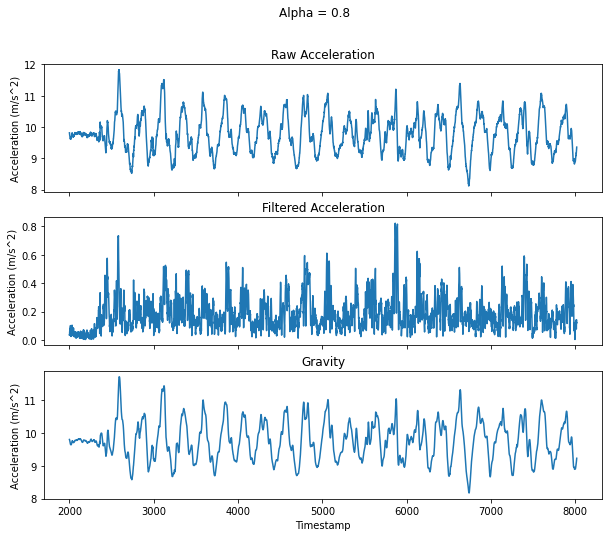

In [66]:
figure, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")

raw_accel_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])
gravity_df.iloc[2000:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(xlabel="Timestamp", ylabel="Acceleration (m/s^2)", title="Gravity", ax=axes[2])

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

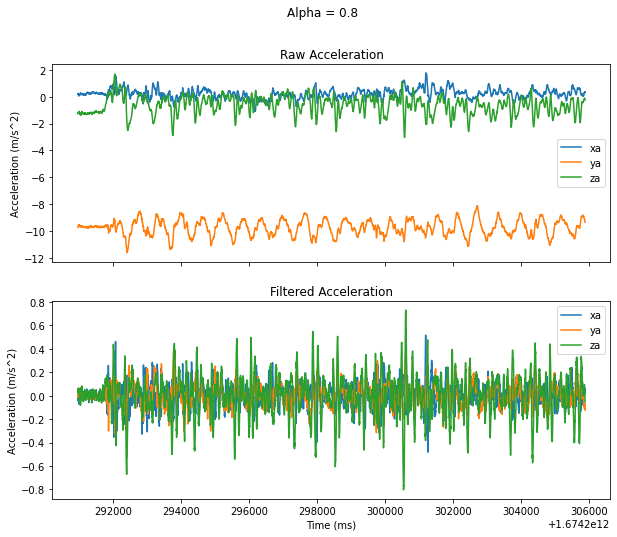

In [82]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
figure.suptitle(f"Alpha = {alpha}")
raw_accel_df.iloc[2000:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[2000:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [83]:
# remove nan values due to rolling mean
imu_df = imu_df.iloc[2000:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [84]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 6017/6017 [00:03<00:00, 1584.30it/s]


In [85]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  0.08915088989534263
GT Distance:  10.118946802419455


In [167]:
groundtruth_df = pd.DataFrame(
    np.concatenate((
        np.expand_dims(sequence_ts[start_index:], axis=1),
        trajectory_t[start_index:, :3, 3]
    ), axis=1),
    columns=["timestamp", "x", "y", "z"]
)

groundtruth_df.loc[:, "imu_t"] =groundtruth_df.apply(lambda x: helpers.nearest(imu_df.timestamp.values, x.timestamp), axis=1)

result = pd.merge(groundtruth_df, imu_df.loc[:, ["timestamp", "x", "y", "z"]], left_on="imu_t", right_on="timestamp", suffixes=("_gt", "_imu"))
result.drop(columns=["imu_t", "timestamp_imu"], inplace=True)

result.loc[:, "error"] = result.apply(lambda x: np.linalg.norm(np.asarray(x[1:4]) - np.asarray(x[4:7])), axis=1)

result.plot(x="timestamp_gt", y="error", xlabel="Timestamp", ylabel="Error (m)", title="Error")

### Moving average filter

In [130]:
win_len = int(frame_rate * 2)

accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

In [108]:
# accel_mavg = imu_df.iloc[:, :4].rolling(window=win_len, step=int(0.25 * win_len)).agg({"timestamp": np.min, "xa": np.mean, "ya": np.mean, "za": np.mean})
# accel_mavg.dropna(inplace=True)
# accel_mavg = pd.merge(imu_df, accel_mavg, on="timestamp", suffixes=("", "vg"), how="left")
# accel_mavg.fillna(method="ffill", inplace=True)

# imu_df.iloc[:, 1:4] = imu_df[["xa", "ya", "za"]].values - accel_mavg[["xavg", "yavg", "zavg"]].values

<AxesSubplot:title={'center':'Gravity'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

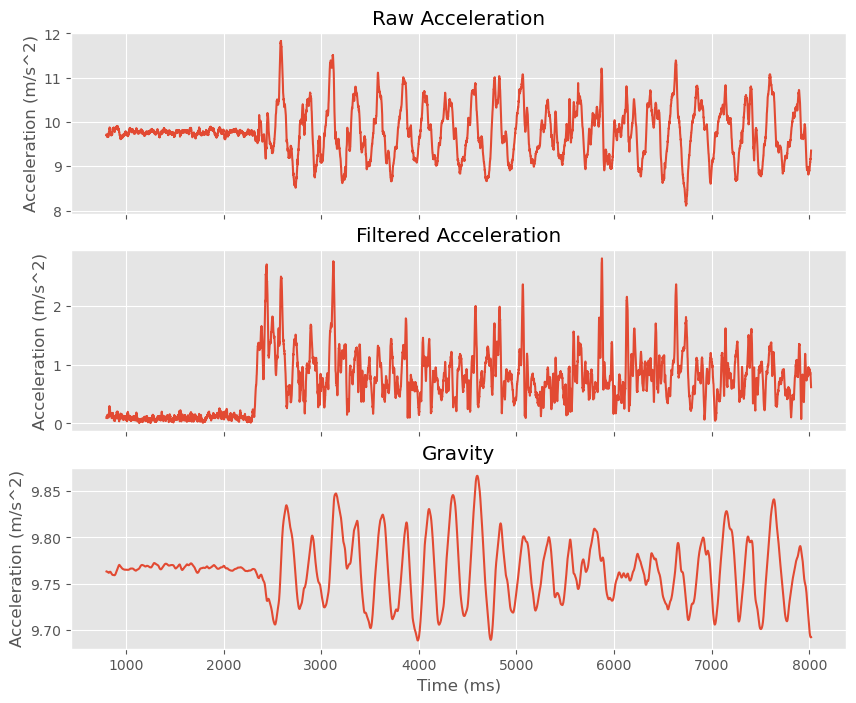

In [131]:
figure, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

raw_accel_df.iloc[win_len:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[win_len:].apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])
# accel_mavg.iloc[win_len:].apply(lambda x: np.linalg.norm(x[7:]), axis=1).plot(x="timestamp", y=["xavg", "yavg", "zavg"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Gravity", ax=axes[2])
accel_mavg.iloc[win_len:].apply(lambda x: np.linalg.norm(x[:3]), axis=1).plot(x="timestamp", y=["x", "y", "z"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Gravity", ax=axes[2])

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

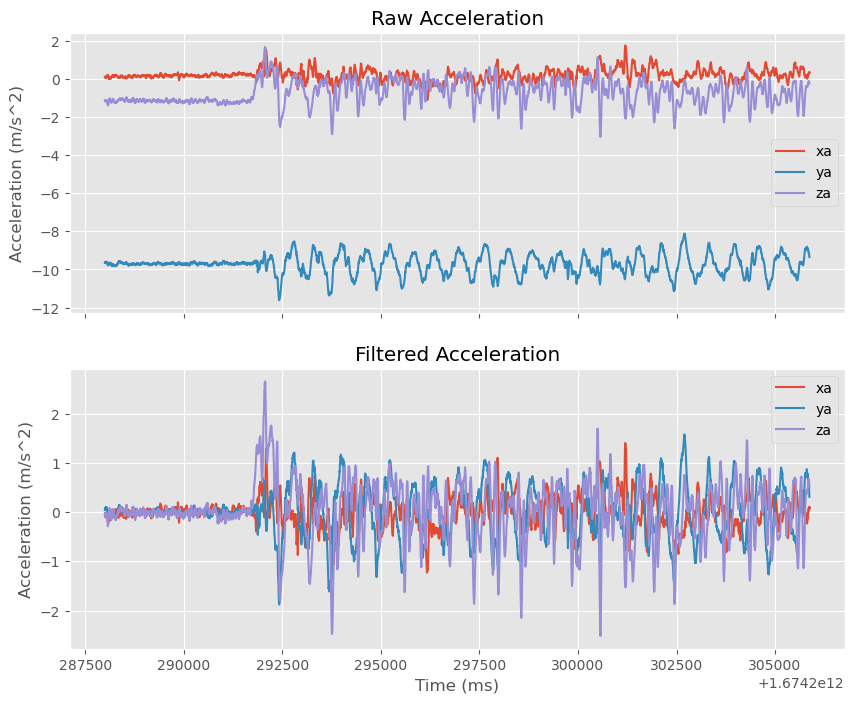

In [132]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
raw_accel_df.iloc[win_len:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.iloc[win_len:].plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [133]:
# remove nan values due to rolling mean
imu_df = imu_df.iloc[win_len:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [134]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    dt = v[7]
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    # velocity = np.dot(rotation_matrix.T, np.array([*velocity, 1]))[:3]
    
    dd = [(velocity[j] * dt) + (0.5 * v[j + 1] * dt * dt) for j in range(3)]
    
    d = np.dot(rotation_matrix, np.array([*dd, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])
    velocity = [velocity[j] + v[j + 1] * dt for j in range(3)]

100%|██████████| 7216/7216 [00:02<00:00, 3535.62it/s]


In [135]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  5.208684912410423
GT Distance:  10.173419170060766


In [136]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

<AxesSubplot:title={'center':'Error'}, xlabel='Timestamp', ylabel='Error (m)'>

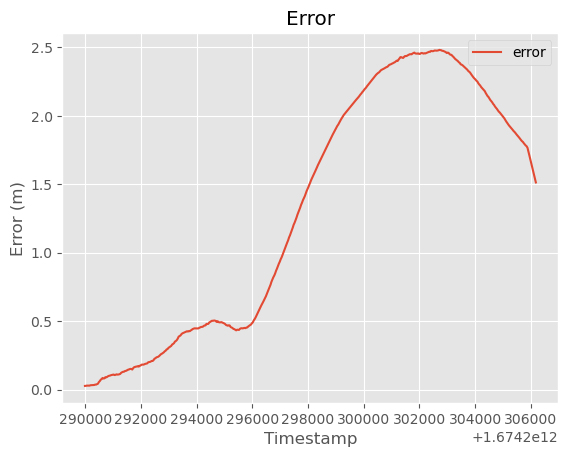

In [118]:
groundtruth_df = pd.DataFrame(
    np.concatenate((
        np.expand_dims(sequence_ts[start_index:], axis=1),
        trajectory_t[start_index:, :3, 3]
    ), axis=1),
    columns=["timestamp", "x", "y", "z"]
)

groundtruth_df.loc[:, "imu_t"] =groundtruth_df.apply(lambda x: helpers.nearest(imu_df.timestamp.values, x.timestamp), axis=1)

result = pd.merge(groundtruth_df, imu_df.loc[:, ["timestamp", "x", "y", "z"]], left_on="imu_t", right_on="timestamp", suffixes=("_gt", "_imu"))
result.drop(columns=["imu_t", "timestamp_imu"], inplace=True)

result.loc[:, "error"] = result.apply(lambda x: np.linalg.norm(np.asarray(x[1:4]) - np.asarray(x[4:7])), axis=1)

result.plot(x="timestamp_gt", y="error", xlabel="Timestamp", ylabel="Error (m)", title="Error")

### Orientation tracking

In [104]:
win_len = int(frame_rate * 4) # 3 seconds window
gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values

In [105]:
# imu_df = imu_df.iloc[win_len:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [106]:
# # calculate displacement and rotation
# rotation_matrix = np.identity(4)

# velocity = [0, 0, 0]

# for i in tqdm.trange(len(imu_df)):
#     v = imu_df.iloc[i].values
#     da = np.degrees([v[j + 4] * v[7] for j in range(3)])
    
#     acceleration = imu_df.iloc[i, [1, 2, 3]].values
#     gravity_rotated = np.dot(helpers.inv_transform(rotation_matrix), np.array([*gravity, 1]))
#     # gravity_rotated = np.dot(rotation_matrix, np.array([*gravity, 1]))
#     acceleration = acceleration - gravity_rotated[:3]
    
#     imu_df.iloc[i, 1] = acceleration[0]
#     imu_df.iloc[i, 2] = acceleration[1]
#     imu_df.iloc[i, 3] = acceleration[2]
    
#     rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])


rotation_matrix = np.identity(3)

velocity = [0, 0, 0]

for i in tqdm.trange(len(imu_df)):
    v = imu_df.iloc[i].values
    angles = np.degrees([v[j + 4] * v[7] for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values
    # acceleration = acceleration - np.dot(rotation_matrix.T, gravity)
    acceleration = acceleration - gravity
    
    imu_df.iloc[i, 1] = acceleration[0]
    imu_df.iloc[i, 2] = acceleration[1]
    imu_df.iloc[i, 3] = acceleration[2]
    
    # rotation_matrix = np.dot(get_rotation_matrix(angles), rotation_matrix)

100%|██████████| 8018/8018 [00:02<00:00, 2745.79it/s]


In [107]:
# win_len = int(frame_rate * 2)

accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()

accel_mavg.fillna(0, inplace=True)

imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

# imu_df = imu_df.iloc[win_len:]

<AxesSubplot:title={'center':'Filtered Acceleration'}, xlabel='Time (ms)', ylabel='Acceleration (m/s^2)'>

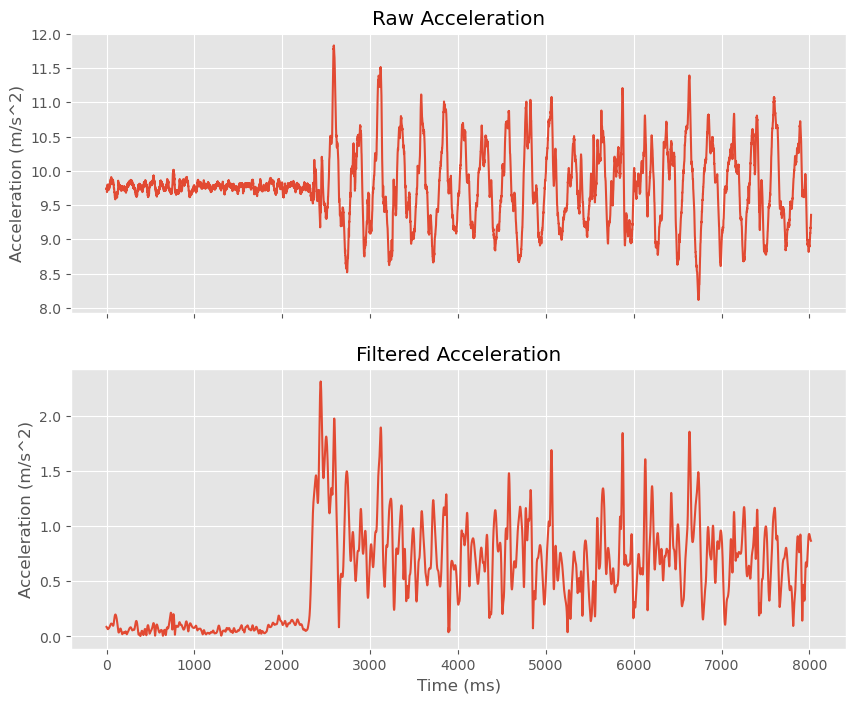

In [108]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

raw_accel_df.apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Raw Acceleration", ax=axes[0])
imu_df.apply(lambda x: np.linalg.norm(x[1:4]), axis=1).plot(x="timestamp", y=["xa", "ya", "za"], xlabel="Time (ms)", ylabel="Acceleration (m/s^2)", title="Filtered Acceleration", ax=axes[1])

In [109]:
imu_df = imu_df.iloc[400:]

In [110]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

100%|██████████| 7617/7617 [00:02<00:00, 2665.82it/s]


In [61]:
# # to store the linear acceleration
# accel_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

# # calculate displacement and rotation
# rotation_matrix = np.identity(4)

# velocity = [0, 0, 0]

# for i in tqdm.tqdm(range(1, len(imu_df))):
#     v = imu_df.iloc[i].values
    
#     dt = v[7]
    
#     # current displacement and rotation
#     da = np.degrees([v[j + 4] * dt for j in range(3)])
    
#     acceleration = imu_df.iloc[i, [1, 2, 3]].values
#     gravity_rotated = np.dot(rotation_matrix, np.array([*gravity, 1]))
#     acceleration = acceleration - gravity_rotated[:3]
    
#     accel_df = pd.concat([accel_df, pd.DataFrame([[v[0], *acceleration]], columns=["timestamp", "x", "y", "z"])])
    
#     d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    
#     d = np.dot(rotation_matrix, np.array([*d, 1]))
    
#     imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
#     imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
#     imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
#     velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
#     rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])


# # resent index for plotting
# accel_df.reset_index(drop=True, inplace=True)

In [111]:
# create trajectory as a pcd
xyz = imu_df.loc[:, ["x", "y", "z"]].values
pcd = helpers.make_pcd(xyz)
pcd.paint_uniform_color([1, 0, 0])

# load ground truth trajectory
sequence_ts = fread.get_timstamps_from_images(os.path.join(data_dir, experiment, trial, subject, f"{sequence:02d}", "frames"), ext=".depth.png")
start_t = helpers.nearest(sequence_ts, imu_df.timestamp.values[0])
start_index = np.where(sequence_ts == start_t)[0][0]

trajectory_t = np.load(pose_file)["trajectory_t"]
pcd_gt = helpers.make_pcd(trajectory_t[start_index:, :3, 3])
pcd_gt.paint_uniform_color([0, 1, 0])
    
print("IMU Distance: ", np.linalg.norm(xyz[-1] - xyz[0]))
print("GT Distance: ", np.linalg.norm(trajectory_t[-1, :3, 3] - trajectory_t[start_index, :3, 3]))

IMU Distance:  10.997310380586514
GT Distance:  10.17501507322044


In [112]:
open3d.visualization.draw_geometries([pcd, pcd_gt])

#### Android API

Experiment to check integration with simulated data

In [78]:
imu = [[2] for _ in range(2000)] + [[0] for _ in range(3000)] + [[-2] for _ in range(2000)]
timestamps = [[i] for i in range(7000)]

data = np.concatenate([timestamps, imu], axis=1)

accel_df = pd.DataFrame(data, columns=["timestamp", "x"])

In [79]:
# accel_df.loc[:, "dt"] = (accel_df.timestamp.values - accel_df.timestamp.values[0]) / 1000
accel_df.loc[:, "dt"] = np.concatenate([[0], (accel_df.timestamp.values[1:] - accel_df.timestamp.values[:-1]) / 1000])
# remove first row
accel_df = accel_df.iloc[1:]

In [80]:
accel_df.loc[:, "dx"] = np.zeros(len(accel_df))

In [76]:
accel_df.values[10]

array([1.2e+01, 2.0e+00, 1.0e-03])

In [84]:
velocity = 0
distance = 0

for i in tqdm.trange(len(accel_df)):
    v = accel_df.iloc[i].values
    dt = v[2]
    distance = distance + (velocity * dt) + (0.5 * v[1] * dt * dt)
    accel_df.iloc[i, 3] = distance
    velocity = velocity + v[1] * dt

100%|██████████| 6999/6999 [00:01<00:00, 5301.51it/s]


<AxesSubplot:xlabel='timestamp'>

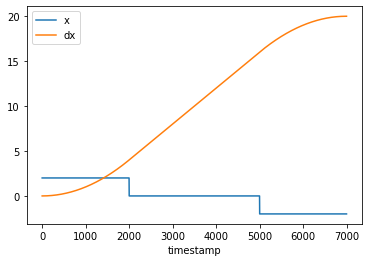

In [85]:
accel_df.set_index("timestamp").loc[:, ["x", "dx"]].plot()

In [ ]:
d = 0.5 * 2 * 4 + 4 * 3 + 0.5 * 4 * 2
print(f"Total distance: {d}")

Linear acceleration from Android API

In [105]:
accel_df = pd.read_csv("data/android/1673931013121/acceleration.csv", names=["timestamp", "x", "y", "z"])
gyro_df = pd.read_csv("data/android/1673931013121/gyroscope.csv", names=["timestamp", "x", "y", "z"])

In [106]:
accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

<AxesSubplot:xlabel='timestamp'>

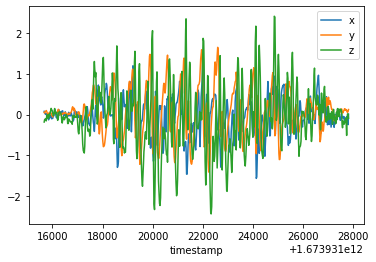

In [107]:
accel_df.loc[125:, ["timestamp", "x", "y", "z"]].set_index("timestamp").plot()

In [108]:
accel_df = accel_df.iloc[125:]

accel_df.loc[:, "gyro_t"] = accel_df.apply(lambda x: nearest(gyro_df.timestamp.values, x.timestamp), axis=1)

imu_df = pd.merge(
    accel_df.loc[:, ["gyro_t", "x", "y", "z"]],
    gyro_df.loc[:, ["timestamp", "x", "y", "z"]],
    left_on="gyro_t",
    right_on="timestamp",
    suffixes=("a", "g")
)

imu_df.drop("gyro_t", axis=1, inplace=True)
imu_df = imu_df.loc[:, ["timestamp", "xa", "ya", "za", "xg", "yg", "zg"]]

In [109]:
# remove first second's data (as it stabilizes the gravity)
# imu_df = imu_df.iloc[400:]
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

In [110]:
# Fill 0 for displacement and angles
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [111]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in range(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        # velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        # imu_df.iloc[i, 11 + j] = imu[j + 4] * dt
        imu_df.iloc[i, 11 + j] = np.degrees(angle[j])

        velocity[j] = velocity[j] + imu[j + 1] * dt

In [112]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [113]:
for i in range(1, len(imu_df)):
    c = imu_df.iloc[i].values           # current readings
    p = imu_df.iloc[i - 1].values       # previous readings

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([c[8], c[9], c[10], 1]))

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

In [114]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

open3d.visualization.draw_geometries([pcd])

In [115]:
np.linalg.norm(xyz[-1])

8.289169564567784

Order 1 IIR filter

In [ ]:
from scipy.signal import lfilter, butter
from scipy.ndimage import gaussian_filter1d

def butter_lowpass(cutoff, fs, order=1):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def apply_iir_filter(data, cutoff, fs, order=1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    filtered_data = lfilter(b, a, data)
    return filtered_data

In [ ]:
y = imu_df.xa.values
x = (imu_df.timestamp.values - imu_df.timestamp.values[0]) / 1000

In [ ]:
y_filtered = apply_iir_filter(y, 0.05, frame_rate)
y_filtered = gaussian_filter1d(y_filtered, sigma=10)

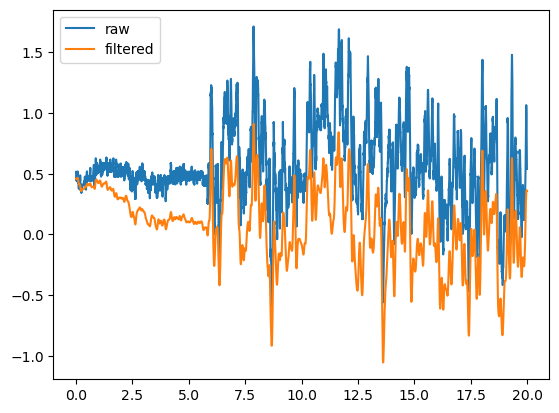

In [ ]:
plt.plot(x, y)
plt.plot(x, y_filtered)
plt.legend(["raw", "filtered"])

In [ ]:
imu_df.loc[:, ["xa", "ya", "za"]] = imu_df.loc[:, ["xa", "ya", "za"]].apply(lambda x: apply_iir_filter(x, 0.1, frame_rate), axis=0)
imu_df.loc[:, ["xa", "ya", "za"]] = imu_df.loc[:, ["xa", "ya", "za"]].apply(lambda x: gaussian_filter1d(x, sigma=10), axis=0)

<AxesSubplot:xlabel='timestamp'>

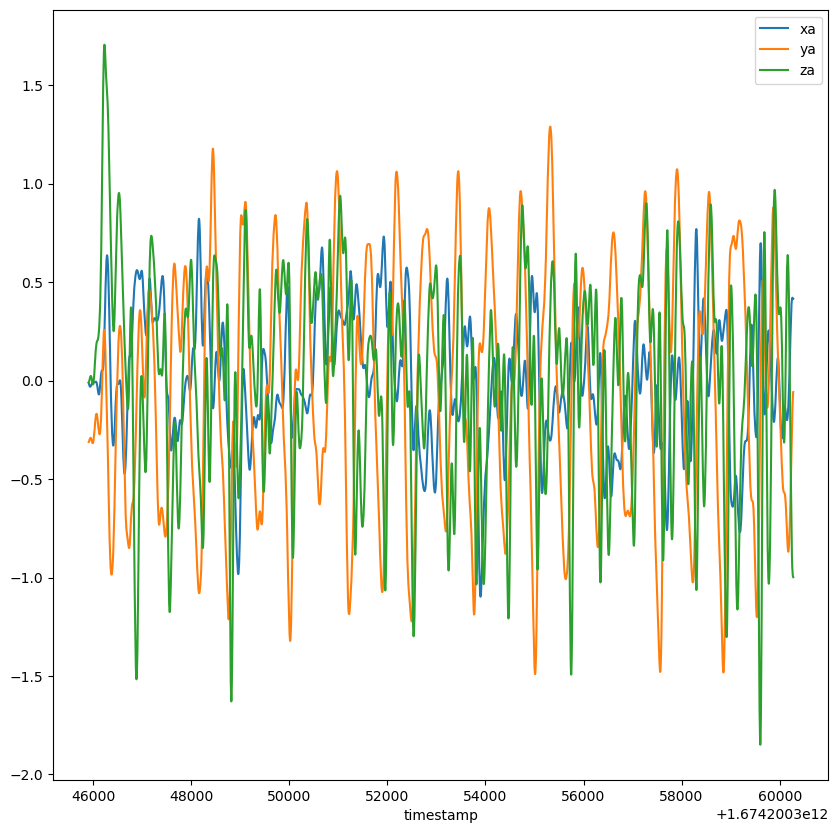

In [ ]:
win_len = int(frame_rate * 5.5) # 4 seconds window

imu_df.iloc[win_len:].plot(x="timestamp", y=["xa", "ya", "za"], figsize=(10, 10))